# Rock Classification and Description Using Conventional and Multispectral Drone Imagery
***
### Domenico M. Crisafulli, Misael M. Morales, Charles Neal and Carlos Torres-Verdin
#### The University of Texas at Austin, 2025
***

In [3]:
import os, cv2, glob
import numpy as np
import pandas as pd
from time import time
from tqdm.notebook import tqdm
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn import metrics as sklmetrics
from skimage import metrics as skimetrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS, SpectralEmbedding
from scipy.stats import gaussian_kde

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import SegformerConfig, SegformerForSemanticSegmentation, SegformerModel

In [4]:
# Global variables
patch_size = 192
n_samples = 50

***
# CoreSegNet2 - Multispectral

In [5]:
f_ms_images = os.listdir('data_new/multispectral_camera')
n_ms_images = len(f_ms_images)
print('Number of multispectral images:', n_ms_images)

Number of multispectral images: 19


In [6]:
ms_names = []
for root, dirs, files in os.walk('data_new/multispectral_camera'):
   for f in files:
      if f.endswith('.png'):
         ms_names.append(os.path.join(root, f))

ms_images_dict = {}
for i in range(n_ms_images):
   ms_images_dict[f_ms_images[i]] = []
   ff = os.path.join('data_new/multispectral_camera', str(f_ms_images[i]))
   for f in os.listdir(ff):
      if f.endswith('.png'):
         impath = os.path.join(ff, f)
         im = np.array(Image.open(impath))
         ms_images_dict[f_ms_images[i]].append(im)
ms_images = {}
for k, v in ms_images_dict.items():
   ms_images[k] = np.stack(v, axis=0)
print('Multispectral images shape:', ms_images[f_ms_images[0]].shape)

Multispectral images shape: (4, 1000, 550)


In [7]:
ms_labels_dict = {}
for i in range(n_ms_images):
   ff = os.path.join('data_new/multispectral_camera', str(f_ms_images[i]))
   ms_labels_dict[f_ms_images[i]] = {'1':{}, '2':{}, '3':{}, '4':{}}
   for f in os.listdir(ff):
      if f.endswith('_labeled.npy'):
         pp = os.path.join(ff, f)
         ch = pp.split('/')[3].split('_')[0] #channel
         vl = pp.split('/')[3].split('_')[-2] #label
         ms_labels_dict[f_ms_images[i]][ch][vl] = np.load(pp)

ms_labels = {}
for i in range(n_ms_images):
    d = ms_labels_dict[f_ms_images[i]]
    k = list(d.keys())
    kk = list(d[k[0]].keys())
    h, w = d[k[0]][kk[0]].shape
    ms_labels[f_ms_images[i]] = np.zeros((4,h,w,6))
    for c in range(1,5):
        for v in range(5):
            if str(v) in d[str(c)].keys():
                ms_labels[f_ms_images[i]][c-1,:,:,v] = d[str(c)][str(v)]
print('Multispectral labels shape:', ms_labels[f_ms_images[0]].shape)

Multispectral labels shape: (4, 1000, 550, 6)


In [8]:
patched_images = []
for i in range(n_ms_images):
    im = ms_images[f_ms_images[i]]
    c, h, w = im.shape
    pad_h = (patch_size - (h % patch_size)) % patch_size
    pad_w = (patch_size - (w % patch_size)) % patch_size
    hh = (pad_h//2, pad_h//2) if (h + 2*(pad_h//2))%patch_size==0 else (pad_h//2+1, pad_h//2)
    ww = (pad_w//2, pad_w//2) if (w + 2*(pad_w//2))%patch_size==0 else (pad_w//2+1, pad_w//2)
    im_pad = np.pad(im, ((0,0), hh, ww), mode='constant', constant_values=0)
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = im_pad[:, i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    patched_images.append(np.array(patches))
patched_images = np.concat(patched_images, axis=0)
print('Patched images shape:', patched_images.shape)

patched_masks = []
for i in range(n_ms_images):
    im = ms_labels[f_ms_images[i]]
    c, h, w, l = im.shape
    pad_h = (patch_size - (h % patch_size)) % patch_size
    pad_w = (patch_size - (w % patch_size)) % patch_size
    hh = (pad_h//2, pad_h//2) if (h + 2*(pad_h//2))%patch_size==0 else (pad_h//2+1, pad_h//2)
    ww = (pad_w//2, pad_w//2) if (w + 2*(pad_w//2))%patch_size==0 else (pad_w//2+1, pad_w//2)
    im_pad = np.pad(im, ((0,0), hh, ww, (0,0)), mode='constant', constant_values=0)
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = im_pad[:, i:i+patch_size, j:j+patch_size, :]
            patches.append(patch)
    patched_masks.append(np.array(patches))
patched_masks = np.concat(patched_masks, axis=0)
print('Patched masks shape:', patched_masks.shape)

Patched images shape: (403, 4, 192, 192)
Patched masks shape: (403, 4, 192, 192, 6)


In [9]:
# Normalize
x_patched_ms = np.moveaxis(patched_images/255.0, 1, -1)
patched_masks_norm = np.where(patched_masks==10, 4, patched_masks)
patched_masks_norm = np.where(patched_masks_norm==13, 5, patched_masks_norm)
y_patched_ms = (patched_masks_norm / 5.0).mean(1)
print('X: {} | Y: {}'.format(x_patched_ms.shape, y_patched_ms.shape))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(x_patched_ms, y_patched_ms, test_size=0.1, random_state=42)

X_train = np.moveaxis(X_train, -1, 1)
X_test = np.moveaxis(X_test, -1, 1)

y_train = np.moveaxis(y_train, -1, 1)
y_test = np.moveaxis(y_test, -1, 1)

ntrain, ntest = X_train.shape[0], X_test.shape[0]
print('X_train: {} | X_test: {}'.format(X_train.shape, X_test.shape))
print('y_train: {} | y_test: {}'.format(y_train.shape, y_test.shape))

X: (403, 192, 192, 4) | Y: (403, 192, 192, 6)
X_train: (362, 4, 192, 192) | X_test: (41, 4, 192, 192)
y_train: (362, 6, 192, 192) | y_test: (41, 6, 192, 192)


In [ ]:
trainloader = DataLoader(TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
),
    batch_size=16,
    shuffle=True,
)

config = SegformerConfig(num_channels=4, num_labels=6, 
                         num_encoder_blocks=4,
                         hidden_sizes=[32, 64, 160, 256],
                         num_attention_heads=[1, 2, 5, 8],
                         strides=[2, 2, 2, 2],)

model = SegformerForSemanticSegmentation(config).to('cuda')
print('# model parameters: {:,}'.format(sum(p.numel() for p in model.parameters())))

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
n_epochs = 100
monitor = 10

train_loss, valid_loss = [], []
start_time = time()
for e in range(n_epochs):
    epoch_train_loss = []
    model.train()
    for i, (x,y) in enumerate(trainloader):
        x, y = x.to('cuda'), y.to('cuda')
        optimizer.zero_grad()
        p = F.interpolate(model(x).logits, size=(patch_size, patch_size), mode='bilinear', align_corners=False, antialias=True)
        loss = criterion(p, y.argmax(1))
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    # monitor
    if e % monitor ==0 or e == 0 or e == n_epochs-1:
        e1 = e+1 if e==n_epochs-1 else e
        prog = 100* e1/n_epochs
        prog_bar = '=' * int(prog//4) + '>' + ' '*(25-int(prog//4))
        impr = 100 * np.abs((train_loss[0] - train_loss[-1]) / train_loss[0]) if e > 0 else 0
        t = train_loss[-1]
        print('Epoch: {}/{} ({:06.2f}%) | Loss: {:1.3f} ({:06.2f}%) | [{}]'.format(e+1, n_epochs, prog, t, impr, prog_bar))
end_time = time()
print('Training time: {:0.2f} minutes'.format((end_time - start_time)/60))
torch.save(model.state_dict(), 'models/SegFormer_ms.pth')
losses = pd.DataFrame({'train_loss': train_loss})
losses.to_csv('models/SegFormer_ms_history.csv', index=False)

# model parameters: 3,717,254
Epoch: 1/100 (000.00%) | Loss: 1.304 (000.00%) | [>                         ]
Epoch: 11/100 (010.00%) | Loss: 1.178 (009.67%) | [==>                       ]
Epoch: 21/100 (020.00%) | Loss: 1.106 (015.22%) | [=====>                    ]
Epoch: 31/100 (030.00%) | Loss: 1.055 (019.09%) | [=======>                  ]
Epoch: 41/100 (040.00%) | Loss: 0.981 (024.75%) | [==========>               ]
Epoch: 51/100 (050.00%) | Loss: 0.963 (026.19%) | [============>             ]
Epoch: 61/100 (060.00%) | Loss: 0.905 (030.59%) | [===============>          ]
Epoch: 71/100 (070.00%) | Loss: 0.870 (033.28%) | [=================>        ]
Epoch: 81/100 (080.00%) | Loss: 0.834 (036.01%) | [====================>     ]
Epoch: 91/100 (090.00%) | Loss: 0.849 (034.91%) | [======================>   ]
Epoch: 100/100 (100.00%) | Loss: 0.801 (038.54%) | [=========================>]
Training time: 3.92 minutes


In [41]:
pred = model(torch.tensor(X_train[:50], dtype=torch.float32).to('cuda'))
pred = F.interpolate(pred.logits, size=(patch_size, patch_size), mode='bilinear', align_corners=False, antialias=True)
pred = pred.detach().cpu().numpy()
pred_labels = np.argmax(pred, axis=1)
true_labels = np.argmax(y_train[:50], axis=1)

print('True labels shape:', true_labels.shape)
print('Predicted labels shape:', pred_labels.shape)

True labels shape: (50, 192, 192)
Predicted labels shape: (50, 192, 192)


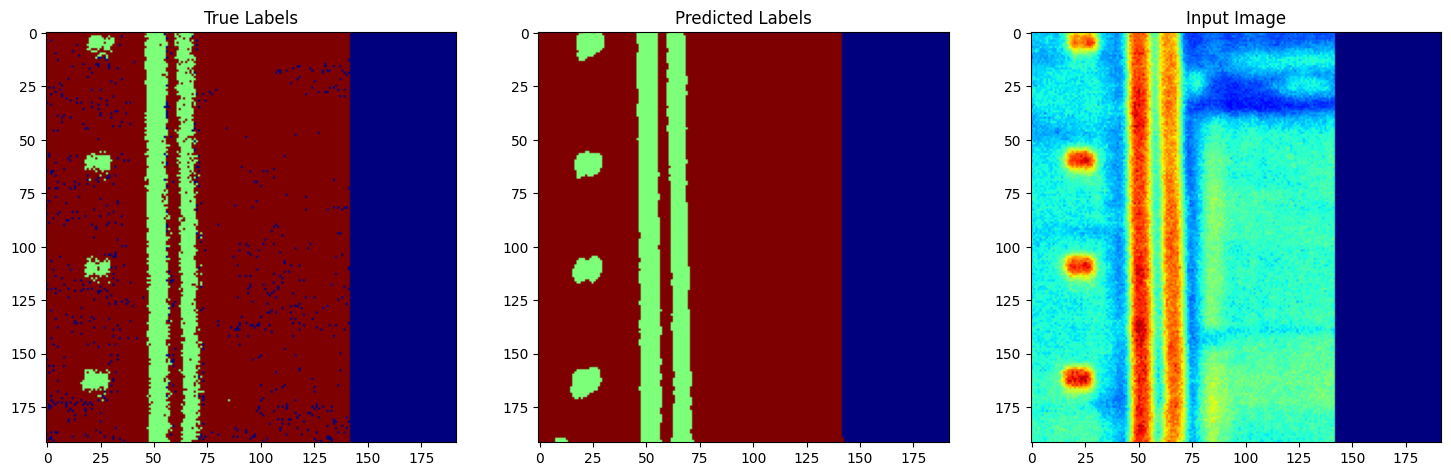

In [52]:
sample_numer = 44

fig, ax = plt.subplots(1,3, figsize=(18,6))

ax[0].imshow(true_labels[sample_numer], cmap='jet')
ax[0].set_title('True Labels')

ax[1].imshow(pred_labels[sample_numer], cmap='jet')
ax[1].set_title('Predicted Labels')

ax[2].imshow(X_train[sample_numer].mean(0), cmap='jet')
ax[2].set_title('Input Image')
plt.show()